# It's the quantization version

In [1]:
from IPython.display import Image
from os import chdir
import numpy as np
import tables as tb
import gudhi as gd
import matplotlib.pyplot as plt
import matplotlib
import time

In [2]:
# read the file
file_name = "function_rips_with_threshold_1000_1"
rank_dim = 0

simplices = []
vertice_id = 0
i = 0

x_values = []
y_values = []

for line in open("../data/"+file_name+".scc"):
    if(line[0]!='#'):
        
        if(i<=1):
            i=i+1
            continue
            
        elif(i==2):
            rank_num=[] # sizes of generating sets
            for j in line.split():
                rank_num.append(int(j))
            i=i+1
            rank_num=rank_num[:-1]
            print("rank_num=",rank_num)
        else:
            block = line.split(';')
            grid = block[0].split()
            grid_x = float(grid[0])
            grid_y = float(grid[1])
            #grid_x = int(float(grid[0])*20)
            #grid_y = int(float(grid[1])*20)
            x_values.append(grid_x)
            y_values.append(grid_y)
            
            
            if len(block)>1:
                face = block[1].split()
                for j in range(len(face)):
                    face[j] = int(face[j])
                simplices.append([grid_x,grid_y,face])
                
            else:
                simplices.append([grid_x,grid_y,[vertice_id]])
                vertice_id += 1
            i=i+1   


simplex_tree = []
start_id=0
for i in range(len(rank_num)-1,-1,-1):
    simplices_i=[]
    for j in range(len(simplices)-start_id-rank_num[i],len(simplices)-start_id):
        simplices_i.append(simplices[j])
    start_id += rank_num[i]
    simplex_tree.append(simplices_i)


#transform face number to vertex number
for i in range(1,len(simplex_tree)):
    for j in range(len(simplex_tree[i])):
        simplex = simplex_tree[i][j]
        face = simplex[2]
        vertices=[]
        for face_id in face:
            vert = simplex_tree[i-1][face_id][2]
            for vert_id in vert:
                if vert_id not in vertices:
                    vertices.append(vert_id)
        simplex_tree[i][j][2]=vertices



## To verify the data structur
## simplices contain all the information we need
#print("the simplex tree:")
#for i in range(len(simplex_tree)):
#    for simplex in simplex_tree[i]:
#        print(simplex)   

rank_num= [447, 347, 181, 50]


In [3]:
x_min=min(x_values)
y_min=min(y_values)
x_length = float(max(x_values)-x_min)
y_length = float(max(y_values)-y_min)

print("x_length=",x_length)
print("y_length=",y_length)

x_length= 0.7492297875079013
y_length= 1.67101010952827


In [4]:
x_range = 19
y_range = 19

end_point=[x_range,y_range]
print("end_point ",end_point)

x_interval = x_length/x_range
y_interval = y_length/y_range

simplex_tree_integer=simplex_tree

for i in range(len(simplex_tree_integer)):
    for j in range(len(simplex_tree_integer[i])):
        #print("[i,j]",[i,j])
        if(x_interval==0):
            simplex_tree_integer[i][j][0]=0
        else:
            simplex_tree_integer[i][j][0] = round((simplex_tree[i][j][0]-x_min)/x_interval)
            
        if(y_interval==0):
            simplex_tree_integer[i][j][1]=0
        else:
            simplex_tree_integer[i][j][1] = round((simplex_tree[i][j][1]-y_min)/y_interval)
        #print("time of change value",end_change-start_change)
        
#for i in range(len(simplex_tree_integer)):
#    for simplex in simplex_tree_integer[i]:
#        print(simplex)

end_point  [19, 19]


## Compute rank invariant

In [5]:
def create_stair(elbow, end_point):
    # stair a path passing through the elbow.
    stair = []
    
    if(elbow[0]==0 or elbow[1]==end_point[1]):
        for i in range(end_point[1]+1):
            stair.append([0,i])
        for j in range(1,end_point[0]+1):
            stair.append([j,i])
    else:
        for i in range(elbow[1]+1):
            stair.append([0,i])   # i=0
        for j in range(elbow[0]):
            stair.append([j+1,i]) # j=0
        for k in range(i+1, end_point[1]+1):
            stair.append([j+1,k]) # k=2,3
        for l in range(j+2, end_point[0]+1):
            stair.append([l,k])
    return stair

def compute_rk(i,j,k,l,barcodes,rank_dim):
# This function computes the value rank(s,t) where s=(i,j) and t = (k,l)
    if(i>k or j>l):
        return 0
    
    s_1 = i + j
    t_1 = k + l
    rank0_inv = 0
    rank1_inv = 0

    for barcode in barcodes:
        if(barcode[0]==0):
            if(barcode[1][0]<=s_1 and barcode[1][1]>t_1):
                rank0_inv = rank0_inv + 1
        elif(barcode[0]==1):
            if(barcode[1][0]<=s_1 and barcode[1][1]>t_1):
                rank1_inv = rank1_inv + 1
    if(rank_dim==0):
        return rank0_inv
    elif(rank_dim==1):
        return rank1_inv

In [6]:
def proj_grid_to_path(simplex, elbow, x_range, y_range):
    x = simplex[0]
    y = simplex[1]
    x0 = elbow[0]
    y0 = elbow[1]

    if((x==0 and y<=y0) or (y==y0 and x<=x0) or (y>=y0 and x==x0) or (y==y_range and x>=x0)):
        proj_p=[x,y]
    elif(x<=x0 and y<=y0):
        proj_p= [x,y0]
    elif(x<=x0 and y>=y0):
        proj_p= [x0,y]
    else:
        proj_p= [x,y_range]
    return proj_p


In [7]:
rank_inv = np.array(np.zeros((x_range+1,y_range+1,x_range+1,y_range+1)))

st = gd.SimplexTree()

#loop for all the elbows
for i in range(x_range+1):
    for j in range(y_range+1):
        elbow = [i,j]
        print("elbow",elbow)
        start_time=time.time()
        #print("time: start building a simplex tree",time.time())
        stair = create_stair(elbow, end_point)
        end_stair=time.time()
        print("time of creating a stair is ",end_stair-start_time,"s")

        # Build the simplex tree
        for ii in range(len(simplex_tree_integer)): #4
            for jj in range(len(simplex_tree_integer[ii])): #[37961, 36515, 20524, 5000]  
                start_loop = time.time()
                simplex = simplex_tree_integer[ii][jj]
                start_grid_id=time.time()
                proj_p = proj_grid_to_path(simplex, elbow, x_range, y_range)
                filtration_value=proj_p[0]+proj_p[1]
                if((st.insert(simplex[2], filtration = filtration_value))==False):
                    st.assign_filtration(simplex[2], filtration = filtration_value)
                
                end_loop = time.time()
                        
        st_time=time.time()                
        print("time of building a simplex tree",st_time-start_time,"s")
        #print("simplices ",st.num_simplices())
        #print("vertices ", st.num_vertices())
        
        #st_gen = st.get_filtration() 
        #for splx in st_gen :
        #    print(splx)
        
        barcodes = st.persistence()
        bc_time = time.time()
        print("time of calculating barcodes ",bc_time-st_time,"s")

        rank_inv_tmp = np.zeros_like(rank_inv)
        
        for barcode in barcodes:
            if(barcode[0]==rank_dim):
                barcode_sid = int(barcode[1][0])
                barcode_eid = barcode[1][1]
                if(barcode_eid>x_range+y_range+2):
                    barcode_eid = x_range+y_range+1
                barcode_eid = int(barcode_eid)

                bar_start_time=time.time()

                for r_s in range(barcode_sid,barcode_eid):#dubug for repeat sum
                    for r_e in range(r_s, barcode_eid):
                        rank_inv_tmp[stair[r_s][0],stair[r_s][1],stair[r_e][0],stair[r_e][1]]+=1 
                bar_end_time=time.time()
                
        rank_inv_tmp[rank_inv>0]=0
        
        rank_inv = rank_inv + rank_inv_tmp
        ri_time = time.time()
        print("time of calculating rank invariance",ri_time-bc_time,"s")
        print("total time for one elbow ",ri_time-start_time,"s")




elbow [0, 0]
time of creating a stair is  1.1920928955078125e-05 s
time of building a simplex tree 0.0026619434356689453 s
time of calculating barcodes  0.0008132457733154297 s
time of calculating rank invariance 0.004977703094482422 s
total time for one elbow  0.008452892303466797 s
elbow [0, 1]
time of creating a stair is  1.0967254638671875e-05 s
time of building a simplex tree 0.002408266067504883 s
time of calculating barcodes  0.0006129741668701172 s
time of calculating rank invariance 0.004893779754638672 s
total time for one elbow  0.007915019989013672 s
elbow [0, 2]
time of creating a stair is  7.867813110351562e-06 s
time of building a simplex tree 0.002519845962524414 s
time of calculating barcodes  0.0006339550018310547 s
time of calculating rank invariance 0.00450897216796875 s
total time for one elbow  0.007662773132324219 s
elbow [0, 3]
time of creating a stair is  8.344650268554688e-06 s
time of building a simplex tree 0.002412080764770508 s
time of calculating barcodes

time of building a simplex tree 0.0024459362030029297 s
time of calculating barcodes  0.0012879371643066406 s
time of calculating rank invariance 0.006003141403198242 s
total time for one elbow  0.009737014770507812 s
elbow [1, 19]
time of creating a stair is  9.298324584960938e-06 s
time of building a simplex tree 0.0025811195373535156 s
time of calculating barcodes  0.0011310577392578125 s
time of calculating rank invariance 0.006298065185546875 s
total time for one elbow  0.010010242462158203 s
elbow [2, 0]
time of creating a stair is  1.1205673217773438e-05 s
time of building a simplex tree 0.0030040740966796875 s
time of calculating barcodes  0.00391387939453125 s
time of calculating rank invariance 0.006063222885131836 s
total time for one elbow  0.012981176376342773 s
elbow [2, 1]
time of creating a stair is  1.0013580322265625e-05 s
time of building a simplex tree 0.002710103988647461 s
time of calculating barcodes  0.00113677978515625 s
time of calculating rank invariance 0.00

time of building a simplex tree 0.00238800048828125 s
time of calculating barcodes  0.0010669231414794922 s
time of calculating rank invariance 0.0053179264068603516 s
total time for one elbow  0.008772850036621094 s
elbow [3, 11]
time of creating a stair is  1.3113021850585938e-05 s
time of building a simplex tree 0.0027692317962646484 s
time of calculating barcodes  0.0007607936859130859 s
time of calculating rank invariance 0.0047931671142578125 s
total time for one elbow  0.008323192596435547 s
elbow [3, 12]
time of creating a stair is  8.821487426757812e-06 s
time of building a simplex tree 0.002396106719970703 s
time of calculating barcodes  0.0008258819580078125 s
time of calculating rank invariance 0.004244804382324219 s
total time for one elbow  0.007466793060302734 s
elbow [3, 13]
time of creating a stair is  1.0251998901367188e-05 s
time of building a simplex tree 0.0024192333221435547 s
time of calculating barcodes  0.0009281635284423828 s
time of calculating rank invarianc

time of calculating rank invariance 0.003453969955444336 s
total time for one elbow  0.0064508914947509766 s
elbow [5, 14]
time of creating a stair is  1.0013580322265625e-05 s
time of building a simplex tree 0.0023889541625976562 s
time of calculating barcodes  0.0006349086761474609 s
time of calculating rank invariance 0.003968954086303711 s
total time for one elbow  0.006992816925048828 s
elbow [5, 15]
time of creating a stair is  1.0967254638671875e-05 s
time of building a simplex tree 0.002471923828125 s
time of calculating barcodes  0.0013151168823242188 s
time of calculating rank invariance 0.003936052322387695 s
total time for one elbow  0.007723093032836914 s
elbow [5, 16]
time of creating a stair is  9.059906005859375e-06 s
time of building a simplex tree 0.002401113510131836 s
time of calculating barcodes  0.0014488697052001953 s
time of calculating rank invariance 0.00432586669921875 s
total time for one elbow  0.008175849914550781 s
elbow [5, 17]
time of creating a stair i

time of building a simplex tree 0.0025870800018310547 s
time of calculating barcodes  0.0010221004486083984 s
time of calculating rank invariance 0.003217935562133789 s
total time for one elbow  0.006827116012573242 s
elbow [7, 10]
time of creating a stair is  1.0013580322265625e-05 s
time of building a simplex tree 0.0024688243865966797 s
time of calculating barcodes  0.0009319782257080078 s
time of calculating rank invariance 0.004035234451293945 s
total time for one elbow  0.007436037063598633 s
elbow [7, 11]
time of creating a stair is  1.0967254638671875e-05 s
time of building a simplex tree 0.0024459362030029297 s
time of calculating barcodes  0.0007538795471191406 s
time of calculating rank invariance 0.0028901100158691406 s
total time for one elbow  0.006089925765991211 s
elbow [7, 12]
time of creating a stair is  1.0013580322265625e-05 s
time of building a simplex tree 0.0024182796478271484 s
time of calculating barcodes  0.0007627010345458984 s
time of calculating rank invari

time of building a simplex tree 0.0024099349975585938 s
time of calculating barcodes  0.0011219978332519531 s
time of calculating rank invariance 0.004897117614746094 s
total time for one elbow  0.00842905044555664 s
elbow [8, 19]
time of creating a stair is  1.0967254638671875e-05 s
time of building a simplex tree 0.002543926239013672 s
time of calculating barcodes  0.0018200874328613281 s
time of calculating rank invariance 0.006276845932006836 s
total time for one elbow  0.010640859603881836 s
elbow [9, 0]
time of creating a stair is  9.059906005859375e-06 s
time of building a simplex tree 0.0024099349975585938 s
time of calculating barcodes  0.0015990734100341797 s
time of calculating rank invariance 0.003337860107421875 s
total time for one elbow  0.0073468685150146484 s
elbow [9, 1]
time of creating a stair is  1.0013580322265625e-05 s
time of building a simplex tree 0.0024292469024658203 s
time of calculating barcodes  0.0011878013610839844 s
time of calculating rank invariance 

time of calculating rank invariance 0.0025072097778320312 s
total time for one elbow  0.005656003952026367 s
elbow [11, 5]
time of creating a stair is  1.0967254638671875e-05 s
time of building a simplex tree 0.002653837203979492 s
time of calculating barcodes  0.0010881423950195312 s
time of calculating rank invariance 0.0029518604278564453 s
total time for one elbow  0.006693840026855469 s
elbow [11, 6]
time of creating a stair is  1.1920928955078125e-05 s
time of building a simplex tree 0.0026209354400634766 s
time of calculating barcodes  0.0012378692626953125 s
time of calculating rank invariance 0.0025200843811035156 s
total time for one elbow  0.006378889083862305 s
elbow [11, 7]
time of creating a stair is  1.0967254638671875e-05 s
time of building a simplex tree 0.0026009082794189453 s
time of calculating barcodes  0.001402139663696289 s
time of calculating rank invariance 0.003735780715942383 s
total time for one elbow  0.007738828659057617 s
elbow [11, 8]
time of creating a 

time of building a simplex tree 0.0024559497833251953 s
time of calculating barcodes  0.0010077953338623047 s
time of calculating rank invariance 0.0032172203063964844 s
total time for one elbow  0.006680965423583984 s
elbow [12, 15]
time of creating a stair is  1.0967254638671875e-05 s
time of building a simplex tree 0.0026848316192626953 s
time of calculating barcodes  0.0009961128234863281 s
time of calculating rank invariance 0.0037348270416259766 s
total time for one elbow  0.007415771484375 s
elbow [12, 16]
time of creating a stair is  1.1682510375976562e-05 s
time of building a simplex tree 0.002440929412841797 s
time of calculating barcodes  0.0007708072662353516 s
time of calculating rank invariance 0.0029108524322509766 s
total time for one elbow  0.006122589111328125 s
elbow [12, 17]
time of creating a stair is  1.0013580322265625e-05 s
time of building a simplex tree 0.0024149417877197266 s
time of calculating barcodes  0.0007510185241699219 s
time of calculating rank invar

time of building a simplex tree 0.0025081634521484375 s
time of calculating barcodes  0.002290964126586914 s
time of calculating rank invariance 0.003324747085571289 s
total time for one elbow  0.00812387466430664 s
elbow [14, 4]
time of creating a stair is  1.5974044799804688e-05 s
time of building a simplex tree 0.0033140182495117188 s
time of calculating barcodes  0.0018219947814941406 s
time of calculating rank invariance 0.003882884979248047 s
total time for one elbow  0.009018898010253906 s
elbow [14, 5]
time of creating a stair is  1.1205673217773438e-05 s
time of building a simplex tree 0.002431154251098633 s
time of calculating barcodes  0.0011010169982910156 s
time of calculating rank invariance 0.003013134002685547 s
total time for one elbow  0.006545305252075195 s
elbow [14, 6]
time of creating a stair is  1.2159347534179688e-05 s
time of building a simplex tree 0.003959178924560547 s
time of calculating barcodes  0.0011887550354003906 s
time of calculating rank invariance 

time of building a simplex tree 0.0024261474609375 s
time of calculating barcodes  0.0013439655303955078 s
time of calculating rank invariance 0.004832029342651367 s
total time for one elbow  0.008602142333984375 s
elbow [15, 19]
time of creating a stair is  1.0967254638671875e-05 s
time of building a simplex tree 0.002500772476196289 s
time of calculating barcodes  0.0011692047119140625 s
time of calculating rank invariance 0.005775928497314453 s
total time for one elbow  0.009445905685424805 s
elbow [16, 0]
time of creating a stair is  1.0013580322265625e-05 s
time of building a simplex tree 0.002469301223754883 s
time of calculating barcodes  0.0009839534759521484 s
time of calculating rank invariance 0.002412080764770508 s
total time for one elbow  0.005865335464477539 s
elbow [16, 1]
time of creating a stair is  1.0013580322265625e-05 s
time of building a simplex tree 0.0024361610412597656 s
time of calculating barcodes  0.0009469985961914062 s
time of calculating rank invariance 

time of building a simplex tree 0.0024497509002685547 s
time of calculating barcodes  0.0010890960693359375 s
time of calculating rank invariance 0.002825021743774414 s
total time for one elbow  0.006363868713378906 s
elbow [18, 8]
time of creating a stair is  1.2159347534179688e-05 s
time of building a simplex tree 0.0024709701538085938 s
time of calculating barcodes  0.0009541511535644531 s
time of calculating rank invariance 0.002889871597290039 s
total time for one elbow  0.006314992904663086 s
elbow [18, 9]
time of creating a stair is  1.0013580322265625e-05 s
time of building a simplex tree 0.002711057662963867 s
time of calculating barcodes  0.0015869140625 s
time of calculating rank invariance 0.0031082630157470703 s
total time for one elbow  0.0074062347412109375 s
elbow [18, 10]
time of creating a stair is  1.0013580322265625e-05 s
time of building a simplex tree 0.0024499893188476562 s
time of calculating barcodes  0.001171112060546875 s
time of calculating rank invariance 0

time of building a simplex tree 0.0024559497833251953 s
time of calculating barcodes  0.0014400482177734375 s
time of calculating rank invariance 0.0055599212646484375 s
total time for one elbow  0.00945591926574707 s
elbow [19, 17]
time of creating a stair is  1.2874603271484375e-05 s
time of building a simplex tree 0.0026428699493408203 s
time of calculating barcodes  0.001461029052734375 s
time of calculating rank invariance 0.004606008529663086 s
total time for one elbow  0.008709907531738281 s
elbow [19, 18]
time of creating a stair is  1.1205673217773438e-05 s
time of building a simplex tree 0.002613067626953125 s
time of calculating barcodes  0.0007061958312988281 s
time of calculating rank invariance 0.0035288333892822266 s
total time for one elbow  0.00684809684753418 s
elbow [19, 19]
time of creating a stair is  1.0967254638671875e-05 s
time of building a simplex tree 0.002655029296875 s
time of calculating barcodes  0.001035928726196289 s
time of calculating rank invariance 

In [8]:
#Now it's rank0_invariance
#np.save("./result/rank"+str(rank_dim)+"_invariance_for_"+file_name,rank_inv)

#for i in range(x_range+1):
#    for j in range(y_range+1):
#        for k in range(i,x_range+1):
#            for l in range(j,y_range+1):
#                if(rank_inv[i,j,k,l]):
#                    print("rank(({0},{1}),({2},{3}))={4}".format(i,j,k,l,int(rank_inv[i,j,k,l])))



## compute multiplicity

In [9]:
#
#m((i,j),(k,l))
def multp(rank, i,j,k,l):
    if(i<0 or j<0 or k>rank.shape[1] or l>rank.shape[0]):   
        return 0
    
    res = rank[i,j,k,l]
    if(k+1<rank.shape[0]):
        res -= rank[i,j,k+1,l]
    if(l+1<rank.shape[1]):
        res -= rank[i,j,k,l+1]
    if(k+1<rank.shape[0] and l+1<rank.shape[1]):
        res += rank[i,j,k+1,l+1]
        
    return res
    

def compute_R_S_incl_excl(rank):
    multiplicity = np.zeros_like(rank)

    for i in range(rank.shape[0]):
        for j in range(rank.shape[1]):
            for k in range(i,rank.shape[0]):
                for l in range(j,rank.shape[1]):
                    m = multp(rank,i,j,k,l)-multp(rank,i-1,j,k,l)-multp(rank,i,j-1,k,l)+multp(rank,i-1,j-1,k,l)
                    if(m!=0):
                        multiplicity[i,j,k,l] = m
    return multiplicity
    

In [10]:
m_start_time = time.time()
m = compute_R_S_incl_excl(rank_inv)

for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        for k in range(i,m.shape[0]):
            for l in range(j,m.shape[1]):
                m_element = multp(rank_inv,i,j,k,l)-multp(rank_inv,i-1,j,k,l)-multp(rank_inv,i,j-1,k,l)+multp(rank_inv,i-1,j-1,k,l)
                if(m_element!=0):
                    m[i,j,k,l] = m_element


m_end_time = time.time()
print("time of calculating multiplicity:",m_end_time-m_start_time,"s")

time of calculating multiplicity: 0.5535898208618164 s


### Draw grid for multiplicity

(20, 20, 20, 20)
m((0,0),(19,19))=1
m((0,3),(1,19))=1
m((0,3),(3,4))=-1
m((0,3),(3,19))=1
m((0,3),(6,4))=1
m((0,3),(9,18))=-1
m((0,3),(9,19))=1
m((0,3),(15,18))=-1
m((0,3),(15,19))=1
m((0,3),(16,6))=-1
m((0,3),(16,18))=1
m((0,3),(19,6))=1
m((0,3),(19,18))=1
m((0,5),(2,19))=1
m((0,7),(2,19))=2
m((0,10),(2,19))=2
m((0,10),(7,18))=-1
m((0,10),(7,19))=1
m((0,10),(17,18))=1
m((0,15),(3,19))=1
m((0,17),(4,19))=1
m((0,17),(13,19))=1
m((0,19),(4,19))=5
m((0,19),(5,19))=5
m((0,19),(6,19))=2
m((0,19),(7,19))=3
m((0,19),(8,19))=6
m((0,19),(9,19))=2
m((0,19),(10,19))=1
m((0,19),(11,19))=4
m((0,19),(12,19))=2
m((0,19),(13,19))=2
m((0,19),(19,19))=4


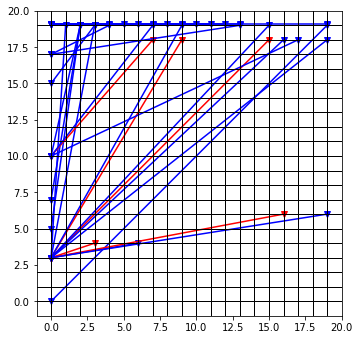

In [11]:
data = np.ones((x_range,y_range)) * np.nan

fig, ax = plt.subplots(1, 1, figsize=(5,5),tight_layout=True)
for x in range(x_range+1):
    ax.axvline(x, lw=1, color='k', zorder=5) # Horizontal 
for y in range(y_range+1):
    ax.axhline(y, lw=1, color='k', zorder=5) # Ordinate
print(m.shape)

for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        for k in range(i,m.shape[0]):
            for l in range(j,m.shape[1]):
                if(m[i,j,k,l]):
                    print("m(({0},{1}),({2},{3}))={4}".format(i,j,k,l,int(m[i,j,k,l])))
                if(m[i,j,k,l]>0):
                    if(i==k and j==l):
                        ax.plot([i, k], [j, l],'bo', linestyle="-")
                    elif(i==k):
                        ax.plot([i+0.08, k+0.08], [j, l],'bv', linestyle="-")
                    elif(j==l):
                        ax.plot([i, k], [j+0.08, l+0.08],'bv',linestyle="-")
                    else:  
                        ax.plot([i, k], [j, l],'bv', linestyle="-")
                if(m[i,j,k,l]<0):
                    if(i==k and j==l):
                        ax.plot([i, k], [j, l],'ro', linestyle="-")
                    elif(i==k):
                        ax.plot([i-0.08, k-0.08], [j, l],'rv', linestyle="-")
                    elif(j==l):
                        ax.plot([i, k], [j-0.08, l-0.08],'rv', linestyle="-")
                    else:  
                        ax.plot([i, k], [j, l], 'rv', linestyle="-")

ax.imshow(data, interpolation='none', extent=[-1,x_range+1, -1, y_range+1], zorder=0)

#ax.axis('off')